<a href="https://colab.research.google.com/github/Bhavnicksm/marathi-neural-machine-translation/blob/main/nmt_seq2seq_attention_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before beginning this notebook, ensure that you have data.csv in available in the working directory

In [1]:
#!pip install torchtext==0.8.0

In [2]:
#!python -m spacy download en

## Hyperparameter declaration

In [3]:
from argparse import Namespace

In [4]:
hype = Namespace(
    LR = 0.01,
    BATCH_SIZE = 128,
    NUM_EPOCHS = 100,
    CLIP = 1,
    DEVICE = None,
    save_checkpoint =True,
    load_checkpoint = False
)

In [5]:
checkpoint = Namespace(
    epoch_num = 0,
    model_params = None,
    optim_params = None,
    scheduler_params = None,
    losses = [],
)

In [6]:
#example usage
hype.BATCH_SIZE

128

In [7]:
#to dict
vars(hype)

{'BATCH_SIZE': 128,
 'CLIP': 1,
 'DEVICE': None,
 'LR': 0.01,
 'NUM_EPOCHS': 100,
 'load_checkpoint': False,
 'save_checkpoint': True}

## Data Processing

### Loading the data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
data = pd.read_csv('data.csv', header=None)
data.columns = ['english', 'marathi']
data.tail()

,english,marathi
40746,Just saying you don't like fish because of the...,हड्डींमुळे मासे आवडत नाही असं म्हणणं हे काय मा...
40747,The Japanese Parliament today officially elect...,आज जपानी संसदेने अधिकृतरित्या र्‍यौतारौ हाशिमो...
40748,Tom tried to sell his old VCR instead of throw...,टॉमने त्याचा जुना व्ही.सी.आर फेकून टाकण्याऐवजी...
40749,You can't view Flash content on an iPad. Howev...,आयपॅडवर फ्लॅश आशय बघता येत नाही. पण तुम्ही त्य...
40750,"In 1969, Roger Miller recorded a song called ""...","१९६९मध्ये रॉजर मिलरने ""यू डोन्ट वॉन्ट माय लव्ह..."


### Building tokenizers

In [10]:
import re
import string
import spacy

In [11]:
#tokenizers for both

def tokenize_mar(text):
  for punc in string.punctuation:
    text = text.replace(punc, " "+punc+" " )
  return [tok.strip() for tok in re.split(r' ', text) if tok!='']

spacy_en = spacy.load('en')

def tokenize_eng(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [12]:
#examples of tokenized sentences
ex_tok_mar = tokenize_mar(data['marathi'][40000])
print(ex_tok_mar)

ex_tok_eng = tokenize_eng(data['english'][40000])
print(ex_tok_eng)

['उद्याची', 'मीटिंग', 'कुठे', 'असणार', 'आहे', 'हे', 'तुम्हाला', 'माहीत', 'आहे', 'का', '?']
['Do', 'you', 'know', 'where', 'tomorrow', "'s", 'meeting', 'is', 'going', 'to', 'be', '?']


### Building Vocabularies

In [13]:
import torchtext
from torchtext.vocab import Vocab
from collections import Counter

print(torchtext.__version__)

0.8.0


In [14]:
def build_vocab(data, tokenizer):
  counter = Counter()
  for text in data:
    counter.update(tokenizer(text))
  return Vocab(counter , specials=('<unk>','<pad>','<sos>','<eos>'),)

In [15]:
mar_vocab = build_vocab(data['marathi'],tokenize_mar)
eng_vocab = build_vocab(data['english'],tokenize_eng)

In [16]:
print(f'Length of Marathi vocab: {len(mar_vocab)}')
print(f'Length of English vocab: {len(eng_vocab)}')

Length of Marathi vocab: 13843
Length of English vocab: 6400


### Changing the dataset to have tokens

In [17]:
import torch

In [18]:
def data_process(data, src_tokenizer, tar_tokenizer, src_vocab, tar_vocab):
  raw_src_iter = iter(data['marathi'])
  raw_tar_iter = iter(data['english'])

  data = []

  for (raw_src, raw_tar) in zip(raw_src_iter,raw_tar_iter):
    src_tensor = torch.tensor([src_vocab.stoi[tok] for tok in src_tokenizer(raw_src)], dtype=torch.long)
    tar_tensor = torch.tensor([tar_vocab.stoi[tok] for tok in tar_tokenizer(raw_tar)], dtype=torch.long)

    data.append((src_tensor,tar_tensor))

  return data

In [19]:
dataset = data_process(data, tokenize_mar, tokenize_eng, mar_vocab, eng_vocab)

### DataLoaders

In [20]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [21]:
hype.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
hype.DEVICE

'cuda'

In [22]:
PAD_IDX = mar_vocab.stoi["<pad>"]
SOS_IDX = mar_vocab.stoi["<sos>"]
EOS_IDX = mar_vocab.stoi["<eos>"]

print(f"pad index: {PAD_IDX}")
print(f"sos index: {SOS_IDX}")
print(f"eos index: {EOS_IDX}")

pad index: 1
sos index: 2
eos index: 3


In [23]:
def batch_proc(data_batch):
  src_batch = []
  tar_batch = []
  
  for (src_item, tar_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([SOS_IDX]), src_item , torch.tensor([EOS_IDX])], dim=0))
    tar_batch.append(torch.cat([torch.tensor([SOS_IDX]), tar_item , torch.tensor([EOS_IDX])], dim=0))
  
  src_batch = pad_sequence(src_batch, padding_value= PAD_IDX)
  tar_batch = pad_sequence(tar_batch, padding_value= PAD_IDX)

  return src_batch, tar_batch

In [24]:
train_iter = DataLoader(dataset, batch_size= hype.BATCH_SIZE , shuffle=True, collate_fn= batch_proc)

In [25]:
# a = next(iter(train_iter))
# print(a)

## Modelling

In [26]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

In [27]:
class Encoder(nn.Module):
  '''
      Encoder for the Sequence to sequence model
  '''
  def __init__(self, input_dim: int, emb_dim: int, encoder_hid_dim: int, decoder_hid_dim: int, dropout_p: float):
    super().__init__()

    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.enc_hid_dim = encoder_hid_dim
    self.dec_hid_dim = decoder_hid_dim
    self.dropout_p = dropout_p


    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.rnn = nn.GRU(emb_dim, encoder_hid_dim, bidirectional= True)
    self.fc = nn.Linear(2*encoder_hid_dim, decoder_hid_dim)
    self.dropout = nn.Dropout(dropout_p)


  def forward(self, src: Tensor) -> Tuple[Tensor]:
    
    embedded = self.dropout(self.embedding(src))

    outputs, hidden = self.rnn(embedded)

    hidden = torch.tanh( self.fc( torch.cat( [ hidden[-2,:,:] , hidden[-1,:,:] ], dim=1) ) )

    return outputs, hidden

In [28]:
class Attention(nn.Module):

  def __init__(self, enc_hid_dim: int, dec_hid_dim: int, attention_dim: int):
    super().__init__()

    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim

    self.attn_in = 2*enc_hid_dim + dec_hid_dim

    self.attn = nn.Linear(self.attn_in, attention_dim)


  def forward(self, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tensor:

    src_len = encoder_outputs.shape[0]

    repeated_dec_hid = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

    encoder_outputs = encoder_outputs.permute(1,0,2)

    energy = torch.tanh(self.attn(torch.cat((repeated_dec_hid,encoder_outputs), dim=2)))

    attention = torch.sum(energy, dim=2)

    return F.softmax(attention, dim=1)

In [29]:
class Decoder(nn.Module):

  def __init__(self, output_dim: int, emb_dim: int, enc_hid_dim: int, dec_hid_dim: int, dropout_p: float, attention: nn.Module ):
    super().__init__()

    self.output_dim = output_dim
    self.emb_dim = emb_dim
    self.enc_hid_dim = enc_hid_dim
    self.dec_hid_dim = dec_hid_dim
    self.dropout_p = dropout_p
    self.attention = attention


    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.GRU( enc_hid_dim*2 +  emb_dim, dec_hid_dim)
    self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
    self.dropout = nn.Dropout(self.dropout_p)
    
  def _weighted_encoder_rep(self, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tensor:

    a = self.attention(decoder_hidden, encoder_outputs)

    a = a.unsqueeze(1)

    encoder_outputs = encoder_outputs.permute(1, 0, 2)

    weighted_encoder_rep = torch.bmm(a, encoder_outputs)

    weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

    return weighted_encoder_rep

  def forward(self, input: Tensor, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tuple[Tensor]:

    input = input.unsqueeze(0)

    embedded = self.dropout(self.embedding(input))

    weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden, encoder_outputs)

    rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

    output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

    output = self.out(torch.cat((output, weighted_encoder_rep, embedded), dim = 1))

    return output, decoder_hidden.squeeze(0)

In [30]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder: nn.Module, decoder: nn.Module, device: torch.device):
      super().__init__()

      self.encoder = encoder
      self.decoder = decoder
      self.device = device

  def forward(self, src: Tensor, trg: Tensor, teacher_forcing_ratio: float = 0.5) -> Tensor:

      batch_size = src.shape[1]
      max_len = trg.shape[0]
      trg_vocab_size = self.decoder.output_dim

      outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

      encoder_outputs, hidden = self.encoder(src)

      # first input to the decoder is the <sos> token
      output = trg[0,:]

      for t in range(1, max_len):
        output, hidden = self.decoder(output, hidden, encoder_outputs)
        outputs[t] = output
        teacher_force = random.random() < teacher_forcing_ratio
        top1 = output.max(1)[1]
        output = (trg[t] if teacher_force else top1)

      return outputs

## Training

In [31]:
import tqdm
from tqdm import notebook

import time

In [32]:
model_hype = Namespace(
    INPUT_DIM = len(mar_vocab),
    OUTPUT_DIM = len(eng_vocab),
    ENC_EMB_DIM = 32,
    DEC_EMB_DIM = 32,
    ENC_HID_DIM = 64,
    DEC_HID_DIM = 64,
    ATTN_DIM = 8,
    ENC_DROPOUT = 0.5,
    DEC_DROPOUT = 0.5,
)

In [33]:
# creating the final model object
enc = Encoder(model_hype.INPUT_DIM, model_hype.ENC_EMB_DIM, model_hype.ENC_HID_DIM, model_hype.DEC_HID_DIM, model_hype.ENC_DROPOUT)
attn = Attention(model_hype.ENC_HID_DIM, model_hype.DEC_HID_DIM, model_hype.ATTN_DIM)
dec = Decoder(model_hype.OUTPUT_DIM, model_hype.DEC_EMB_DIM, model_hype.ENC_HID_DIM, model_hype.DEC_HID_DIM, model_hype.DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, hype.DEVICE).to(hype.DEVICE)

In [34]:
def init_model(model: nn.Module):
  for name, param in model.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data, mean=0., std = 0.01)
    else:
      nn.init.constant_(param.data, 0.)

model.apply(init_model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(13843, 32)
    (rnn): GRU(32, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (embedding): Embedding(6400, 32)
    (rnn): GRU(160, 64)
    (out): Linear(in_features=224, out_features=6400, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_params (model: nn.Module):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {count_params(model):,} parameters in the model.")

There are 2,178,600 parameters in the model.


In [36]:
optimizer = optim.Adam(model.parameters(), lr= hype.LR)

tar_PAD_IDX = eng_vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=tar_PAD_IDX)

In [37]:
#build scheduler for plateu of the loss rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience=10, threshold=0.001, min_lr= 10e-7, verbose= True)

In [38]:
def train(model: nn.Module, iterator: torch.utils.data.DataLoader, optimizer: optim.Optimizer, criteria: nn.Module , clip: float, device: str):
  model.train()

  epoch_loss = 0

  for _, (src,tar) in enumerate(iterator):
    src, tar = src.to(device), tar.to(device)

    optimizer.zero_grad()

    output = model(src, tar)

    output = output[1:].view(-1, output.shape[-1])
    tar = tar[1:].view(-1)

    loss = criteria(output, tar)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    epoch_loss += loss.item()
  
  return epoch_loss/len(iterator)

In [39]:
vars(checkpoint)

{'epoch_num': 0,
 'losses': [],
 'model_params': None,
 'optim_params': None,
 'scheduler_params': None}

In [40]:
#hype.load_checkpoint = False

In [41]:
if hype.load_checkpoint:
  checkpoint = torch.load('seq2seq_attn_checkpoint.pth')

  model.load_state_dict(checkpoint.model_params)
  optimizer.load_state_dict(checkpoint.optim_params)
  scheduler.load_state_dict(checkpoint.scheduler_params)
  print(f"epochs: {checkpoint.epoch_num} || loss: {checkpoint.losses}")

In [42]:
# model.state_dict()

In [43]:
vars(hype)

{'BATCH_SIZE': 128,
 'CLIP': 1,
 'DEVICE': 'cuda',
 'LR': 0.01,
 'NUM_EPOCHS': 100,
 'load_checkpoint': False,
 'save_checkpoint': True}

In [44]:
epoch_t = notebook.trange(hype.NUM_EPOCHS, desc='loss')

for epoch in epoch_t:

  train_loss = train(model,train_iter, optimizer, criterion, hype.CLIP, hype.DEVICE)

  checkpoint.epoch_num += 1 
  checkpoint.model_params = model.state_dict()
  checkpoint.optim_params = optimizer.state_dict()
  checkpoint.scheduler_params = scheduler.state_dict()
  checkpoint.losses.append(train_loss)

  if hype.save_checkpoint:
    torch.save(checkpoint,'seq2seq_attn_checkpoint.pth')
    
  scheduler.step(train_loss)

  epoch_t.set_description(f"loss: {train_loss: .5f}")
  epoch_t.refresh()

Epoch    59: reducing learning rate of group 0 to 1.0000e-03.



In [ ]:
# # Saving a checkpoint

# if hype.save_checkpoint:
#   checkpoint.model_params = model.state_dict()
#   checkpoint.optim_params = optimizer.state_dict()
#   torch.save(checkpoint,'seq2seq_attn_checkpoint.pth')  

## Loss Curve

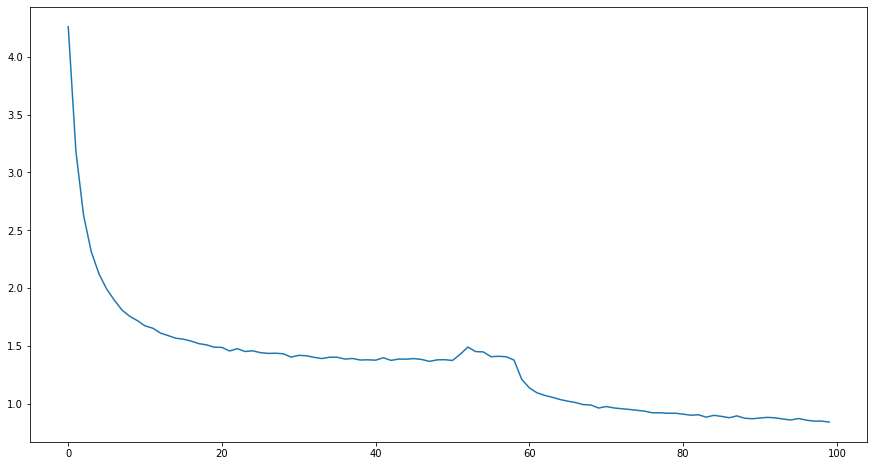

In [45]:
plt.figure(figsize=(15,8))
plt.plot(checkpoint.losses)
plt.show()

## Inference

In [46]:
def translate_sentence(sentence, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        tokens = [token.lower() for token in src_tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_vocab.stoi['<sos>']] + tokens + [src_vocab.stoi['<eos>']]
        
    src_indexes = [src_vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    # mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_vocab.stoi['<sos>']]

    # attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs,)

        # attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab.stoi['<eos>']:
            break
    
    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [53]:
sentence = data['marathi'][22222]
translation = data['english'][22222]
print(sentence)
out = translate_sentence(sentence, tokenize_mar, tokenize_eng, mar_vocab, eng_vocab, model, hype.DEVICE)
print(translation)
print(out)

टॉम ताबडतोब रागावला.
Tom got angry right away.
['Tom', 'immediately', 'angry', 'right', 'away', '.', '<eos>']


## BLEU Score

In [48]:
from torchtext.data.metrics import bleu_score

In [49]:
def calculate_bleu_score(data, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, model, device):
  
  trgs = []
  preds = []

  for i in range(len(data)):
    src = data['marathi'][i]
    trg = data['english'][i]

    trg = trg_tokenizer(trg)

    pred = translate_sentence(src, src_tokenizer, trg_tokenizer, src_vocab, trg_vocab, model, device)

    #preds.append(trg)
    preds.append(pred[:-1])
    trgs.append([trg])

  return bleu_score(preds, trgs)

In [50]:
bleu = calculate_bleu_score(data, tokenize_mar, tokenize_eng, mar_vocab, eng_vocab, model, hype.DEVICE)
print(f"The BLEU score is {bleu*100:.2f}")

The BLEU score is 52.74
